In [1]:
import numpy as np
import astropy
from astropy.io import fits
from astropy import wcs
import jwst
print('jwst version: ', jwst.__version__, jwst.__file__)
from jwst.assign_wcs import nirspec
from jwst import datamodels

jwst version:  0.9.3a.dev96 /internal/1/astropy/jwst/jwst/__init__.py


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
!/internal/1/astropy/jwst/scripts/strun assign_wcs.cfg msa.fits

2018-04-16 10:08:47,895 - stpipe.assign_wcs - INFO - AssignWcsStep instance created.
2018-04-16 10:08:47,916 - stpipe.assign_wcs - INFO - Step assign_wcs running with args ('msa.fits',).
2018-04-16 10:08:48,393 - stpipe.assign_wcs - INFO - Retrieving open slitlets for msa_metadata_id = 1
2018-04-16 10:08:48,671 - stpipe.assign_wcs - INFO - gwa_ytilt is 0.1789360195398331 deg
2018-04-16 10:08:48,671 - stpipe.assign_wcs - INFO - gwa_xtilt is 0.2856041491031647 deg
2018-04-16 10:08:48,671 - stpipe.assign_wcs - INFO - theta_y correction: 0.000963676070271049 deg
2018-04-16 10:08:48,672 - stpipe.assign_wcs - INFO - theta_x correction: 0.0 deg
2018-04-16 10:08:49,199 - stpipe.assign_wcs - INFO - Slits projected on detector NRS1: [1]
2018-04-16 10:08:49,199 - stpipe.assign_wcs - INFO - Computing WCS for 1 open slitlets
2018-04-16 10:08:49,271 - stpipe.assign_wcs - INFO - gwa_ytilt is 0.1789360195398331 deg
2018-04-16 10:08:49,271 - stpipe.assign_wcs - INFO - gwa_xtilt is 0.2856041491031647 de

In [4]:
im = datamodels.ImageModel('msa_assign_wcs.fits')

In [5]:
print("Instrument Configuration")
print("Detector: {}".format(im.meta.instrument.detector))
print("GWA: {}".format(im.meta.instrument.grating))
print("Filter: {}".format(im.meta.instrument.filter))
print("Lamp: {}".format(im.meta.instrument.lamp_state))
print("GWA_XTILT: {}".format(im.meta.instrument.gwa_xtilt))
print("GWA_YTILT: {}".format(im.meta.instrument.gwa_ytilt))
print("GWA_TTILT: {}".format(im.meta.instrument.gwa_tilt))
      

Instrument Configuration
Detector: NRS1
GWA: G395M
Filter: OPAQUE
Lamp: LINE3
GWA_XTILT: 0.2856041491031647
GWA_YTILT: 0.1789360195398331
GWA_TTILT: 40.28447479156018


2018-04-16 10:08:51,754 - stpipe - INFO - Retrieving open slitlets for msa_metadata_id = 1


Open slits
[Slit(name=1, shutter_id=4699, xcen=319, ycen=13, ymin=-0.55000000000000004, ymax=0.55000000000000004, quadrant=3, source_id=1, shutter_state='x', source_name='lamp', source_alias='foo', stellarity=100.0, source_xpos=-0.5, source_ypos=0.5)]


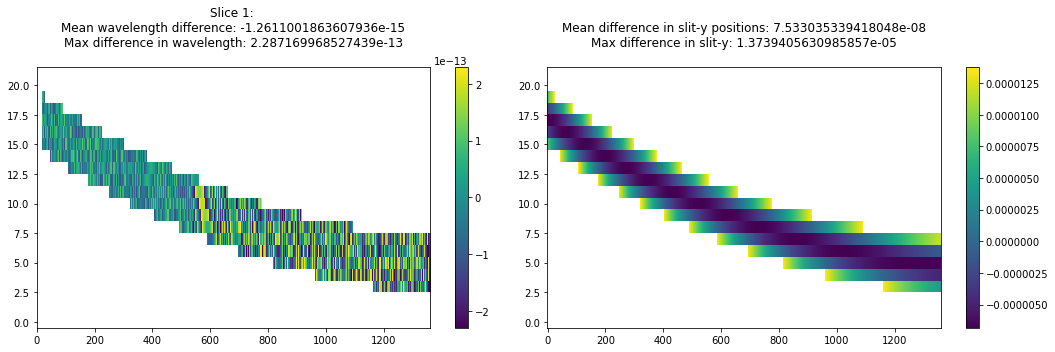

In [6]:
trace = "Trace_MOS_3_319_013_V96215001001P0000000002103_41543_JLAB88.fits"
tr = fits.open(trace)
#tr.info()
lam1 = tr[4].data
slit1 = tr[5].data
msay1 = tr[7].data
pyw = wcs.WCS(tr[4].header)
tr.close()

# Create x, y indices using the Trace WCS
y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
x1, y1 = pyw.all_pix2world(x, y, 0)

# Get the WCS for this particular slice
slits = nirspec.get_open_slits(im)
print("Open slits")
print(slits)
name = slits[0].name
wcs_slice = nirspec.nrs_wcs_set_input(im, name)
# Compute ra, dec and lambda
ra, dec, lam = wcs_slice(x1-1, y1-1) #use 0-based coordinates
lam *= 10**-6

# For pixels where lam == NaN, set the value to -1
notnan = ~np.isnan(lam)

# Compute the difference in wavelength
diff = lam1 - lam
title = "Slice {}: \n".format(name)
title += "Mean wavelength difference: {}\n".format(np.mean(diff[notnan]))
title += "Max difference in wavelength: {}\n".format(np.max(diff[notnan]))

# Compute the difference in slit-y positions
detector2slit = wcs_slice.get_transform("detector", "slit_frame")
sx, sy, _ = detector2slit(x1-1, y1-1)
diffslit = sy - slit1

# Plot differences and some statistics
titles = "Mean difference in slit-y positions: {}\n".format(np.mean(diffslit[notnan]))
titles += "Max difference in slit-y: {}\n".format(np.max(diffslit[notnan]))
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1,2,1)
i1 = ax1.imshow(diff, aspect='auto')
plt.title(title)
plt.colorbar(i1, ax=ax1 )
ax2 = plt.subplot(1,2,2)
i2 = ax2.imshow(diffslit, aspect='auto')
plt.title(titles)
plt.colorbar(i2, ax=ax2)

fig.tight_layout()